## **The Scenario**

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The aim of this project is to predict the sale price of residential homes in Ames, Iowa. We will utilize feature engineering and regression algorithms to achieve the lowest prediction error 


The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
# making sure to responsibly manage database connections! :) 
engine.dispose()
print(houseprices_df.shape)
houseprices_df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


Before any data wrangling, we have 81 columns with 1460 rows.

In [ ]:
len(houseprices_df.select_dtypes(include=['float64', 'int64']).count())

38

Of those 81 columns, 38 are numeric variables.

#**Data Cleaning**

In [ ]:
fill_list = []
percent_missing = []
for col in houseprices_df:
  if houseprices_df[col].isnull().sum() != 0:
    percent_missing.append({
        'variable': col,
        'percent missing': houseprices_df[col].isnull().sum()*100/houseprices_df[col].isnull().count()
        })
    fill_list.append(col)

print("We have {} columns with missing values".format(len(fill_list)))
print()
percent_missing

We have 19 columns with missing values



[{'percent missing': 17.73972602739726, 'variable': 'lotfrontage'},
 {'percent missing': 93.76712328767124, 'variable': 'alley'},
 {'percent missing': 0.547945205479452, 'variable': 'masvnrtype'},
 {'percent missing': 0.547945205479452, 'variable': 'masvnrarea'},
 {'percent missing': 2.5342465753424657, 'variable': 'bsmtqual'},
 {'percent missing': 2.5342465753424657, 'variable': 'bsmtcond'},
 {'percent missing': 2.6027397260273974, 'variable': 'bsmtexposure'},
 {'percent missing': 2.5342465753424657, 'variable': 'bsmtfintype1'},
 {'percent missing': 2.6027397260273974, 'variable': 'bsmtfintype2'},
 {'percent missing': 0.0684931506849315, 'variable': 'electrical'},
 {'percent missing': 47.26027397260274, 'variable': 'fireplacequ'},
 {'percent missing': 5.5479452054794525, 'variable': 'garagetype'},
 {'percent missing': 5.5479452054794525, 'variable': 'garageyrblt'},
 {'percent missing': 5.5479452054794525, 'variable': 'garagefinish'},
 {'percent missing': 5.5479452054794525, 'variable'

We note that we have 19 columns with missing values. Of those 19, 4 variables have over 80% of missing data. We will drop these 4 columns and move on to filling in missing values for the remaining 15.

In [ ]:
# We are dropping columns:'alley', 'poolqc', 'fence', 'miscfeature' as these have
# more than 80% of the data missing
houseprices_df = houseprices_df.drop(['alley','poolqc', 'fence', 'miscfeature'], axis=1)
dropped = ['alley', 'poolqc', 'fence', 'miscfeature'] 
  
for elem in dropped:
  fill_list.remove(elem)

print("We now have {} columns with missing values".format(len(fill_list)))

We now have 15 columns with missing values


***Filling missing values***

We will fill our missing categorical variables with the value occuring most frequent.

In [ ]:
fill_numeric_col = houseprices_df[fill_list].select_dtypes(include=['float64', 'int64'])
fill_categorical_col = houseprices_df[fill_list].select_dtypes(exclude=['float64', 'int64'])

In [ ]:
for col in fill_categorical_col:
  houseprices_df[col] = houseprices_df[col].fillna(houseprices_df[col].mode()[0])

We drop garageyrblt from our fill_numeric_col as missing values for this variable will be handled differently.

In [ ]:
fill_numeric_col = fill_numeric_col.drop(['garageyrblt'], axis=1)
houseprices_df['garageyrblt'] = houseprices_df['garageyrblt'].fillna(houseprices_df['garageyrblt'].median())

for col in fill_numeric_col: 
  houseprices_df[col] = houseprices_df[col].fillna(houseprices_df[col].mean())

In [ ]:
houseprices_df['garageyrblt'] = houseprices_df['garageyrblt'].astype(int)

In [ ]:
houseprices_df = houseprices_df.drop(['id'], axis=1)
numeric_col = houseprices_df.select_dtypes(include=['float64', 'int64'])
categorical_col = houseprices_df.select_dtypes(exclude=['float64', 'int64'])

# **Exploratory Data Analysis and Feature Selection**

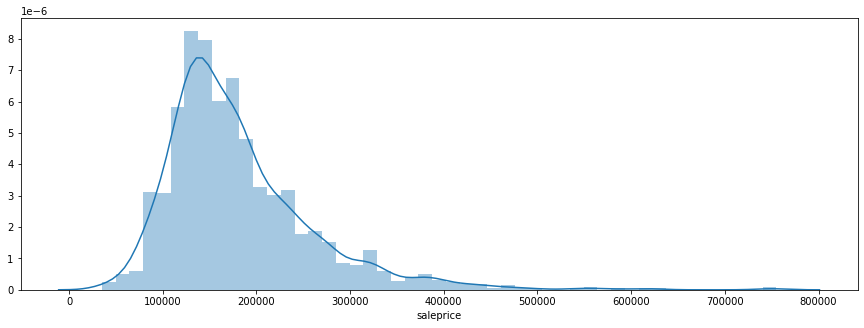

Skewness: 1.882876
Kurtosis: 6.536282


In [ ]:
# -----> Plot the distribution of our target variable. 
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.distplot(houseprices_df['saleprice'], label= 'yes')

plt.show()
#plt.hist(houseprices_df['saleprice'])
# sns.title("distribution of sale prices")
# sns.xlabel("sale prices")
# sns.ylabel("occurrences")
# sns.show()

#skewness and kurtosis
print("Skewness: %f" % houseprices_df['saleprice'].skew())
print("Kurtosis: %f" % houseprices_df['saleprice'].kurt())

We have a right-skewed distribution showing the peak occuring between 100,000 and 200,000. Since 'saleprice' is not normal, we will apply long transformation when we create our model. 

**Numerical variable selection**

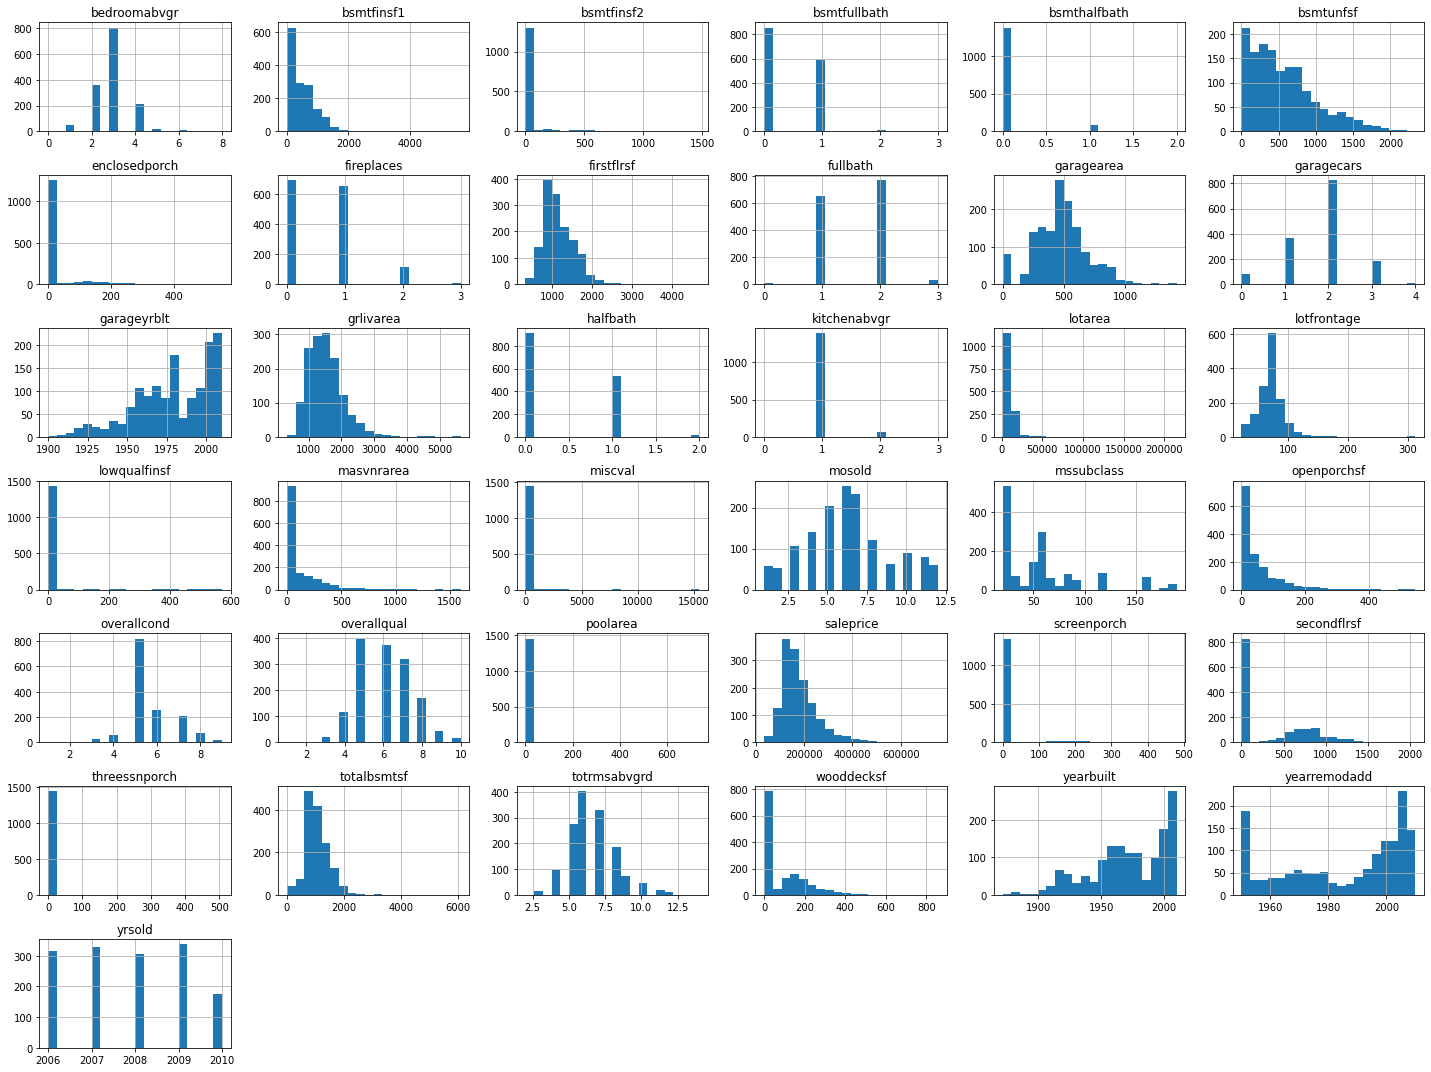

In [ ]:
numeric_col.hist(bins=20, figsize=(20,15))
plt.tight_layout()
plt.show()

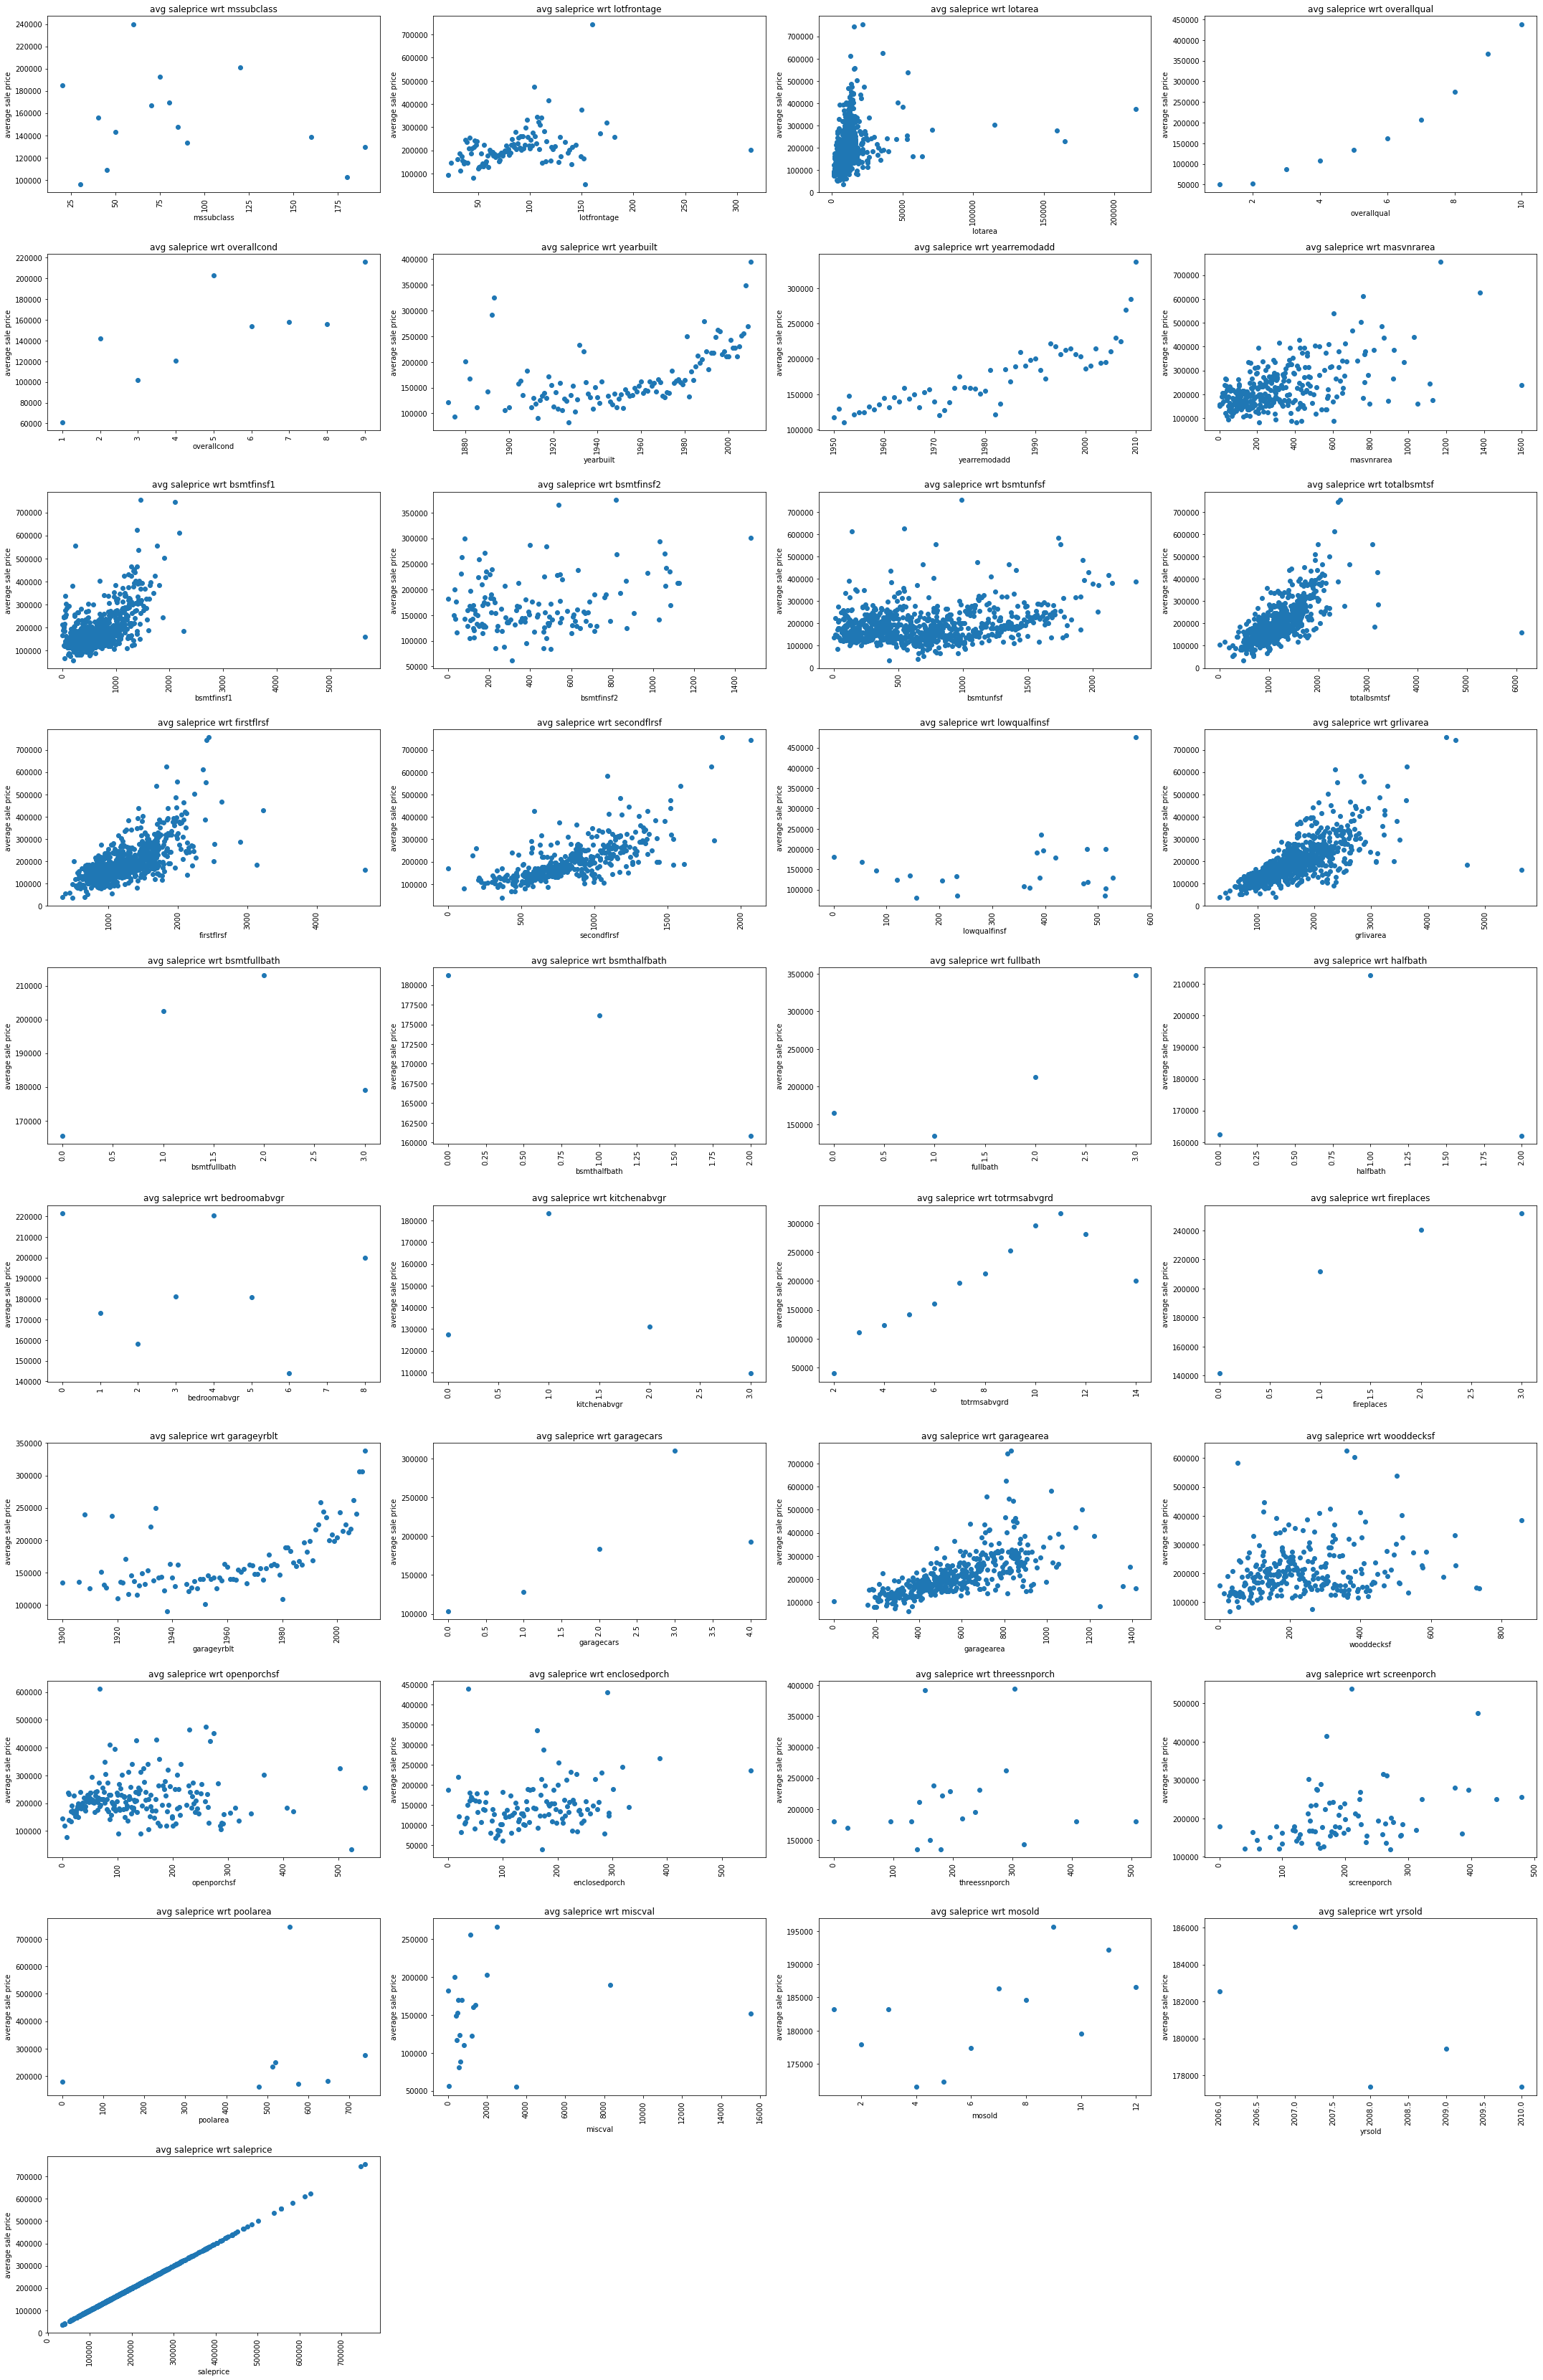

In [ ]:
plt.figure(figsize=(30,50))

for index, column in enumerate(numeric_col):
    plt.subplot(11,4,index+1)
    plt.scatter(houseprices_df.groupby(column)["saleprice"].mean().index, houseprices_df.groupby(column)["saleprice"].mean())
    plt.title("avg saleprice wrt {}".format(column))
    plt.ylabel("average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

From our plots, we note that 'totalbsmtsf' and 'grlivarea' appear to be linearly related with 'saleprice'. Both relationships are positive, which tells us that as one variable increases, the other also increases. In the case of 'totalbsmtsf', we can see that the slope of the linear relationship is particularly high.

'overallqual' and 'yearremodadd' also seem to be related with 'saleprice'. However, the relationship seems to be stronger for 'overallqual', where the scatter plot shows how sales prices increase with the overall quality.

In [ ]:
correlations = houseprices_df[houseprices_df.columns[1:]].corr()['saleprice'][:].abs()
sorted_corr = correlations.sort_values(ascending=False)
sorted_corr.head(50)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.475241
fireplaces       0.466929
garageyrblt      0.466754
bsmtfinsf1       0.386420
lotfrontage      0.334901
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Square footage of a house and age of house is a big determining factor for sale price. I added these to our dataframe and check correlations again. 

In [ ]:
houseprices_df['house_age'] = houseprices_df['yrsold'] - houseprices_df['yearbuilt']
houseprices_df['total_area'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']

In [ ]:
correlations = houseprices_df[houseprices_df.columns[1:]].corr()['saleprice'][:].abs()
sorted_corr = correlations.sort_values(ascending=False)
sorted_corr.head(50)

saleprice        1.000000
overallqual      0.790982
total_area       0.782260
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
house_age        0.523350
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.475241
fireplaces       0.466929
garageyrblt      0.466754
bsmtfinsf1       0.386420
lotfrontage      0.334901
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: salepr

From our numeric variables, I'll be selecting the top 7 most correlated variables which end up being the following:

* total_area  
* overallqual      
* grlivarea        
* garagecars       
* garagearea       
* totalbsmtsf      
* firstflrsf       

**We will now select our categorical variable selection to utilize in our model.**

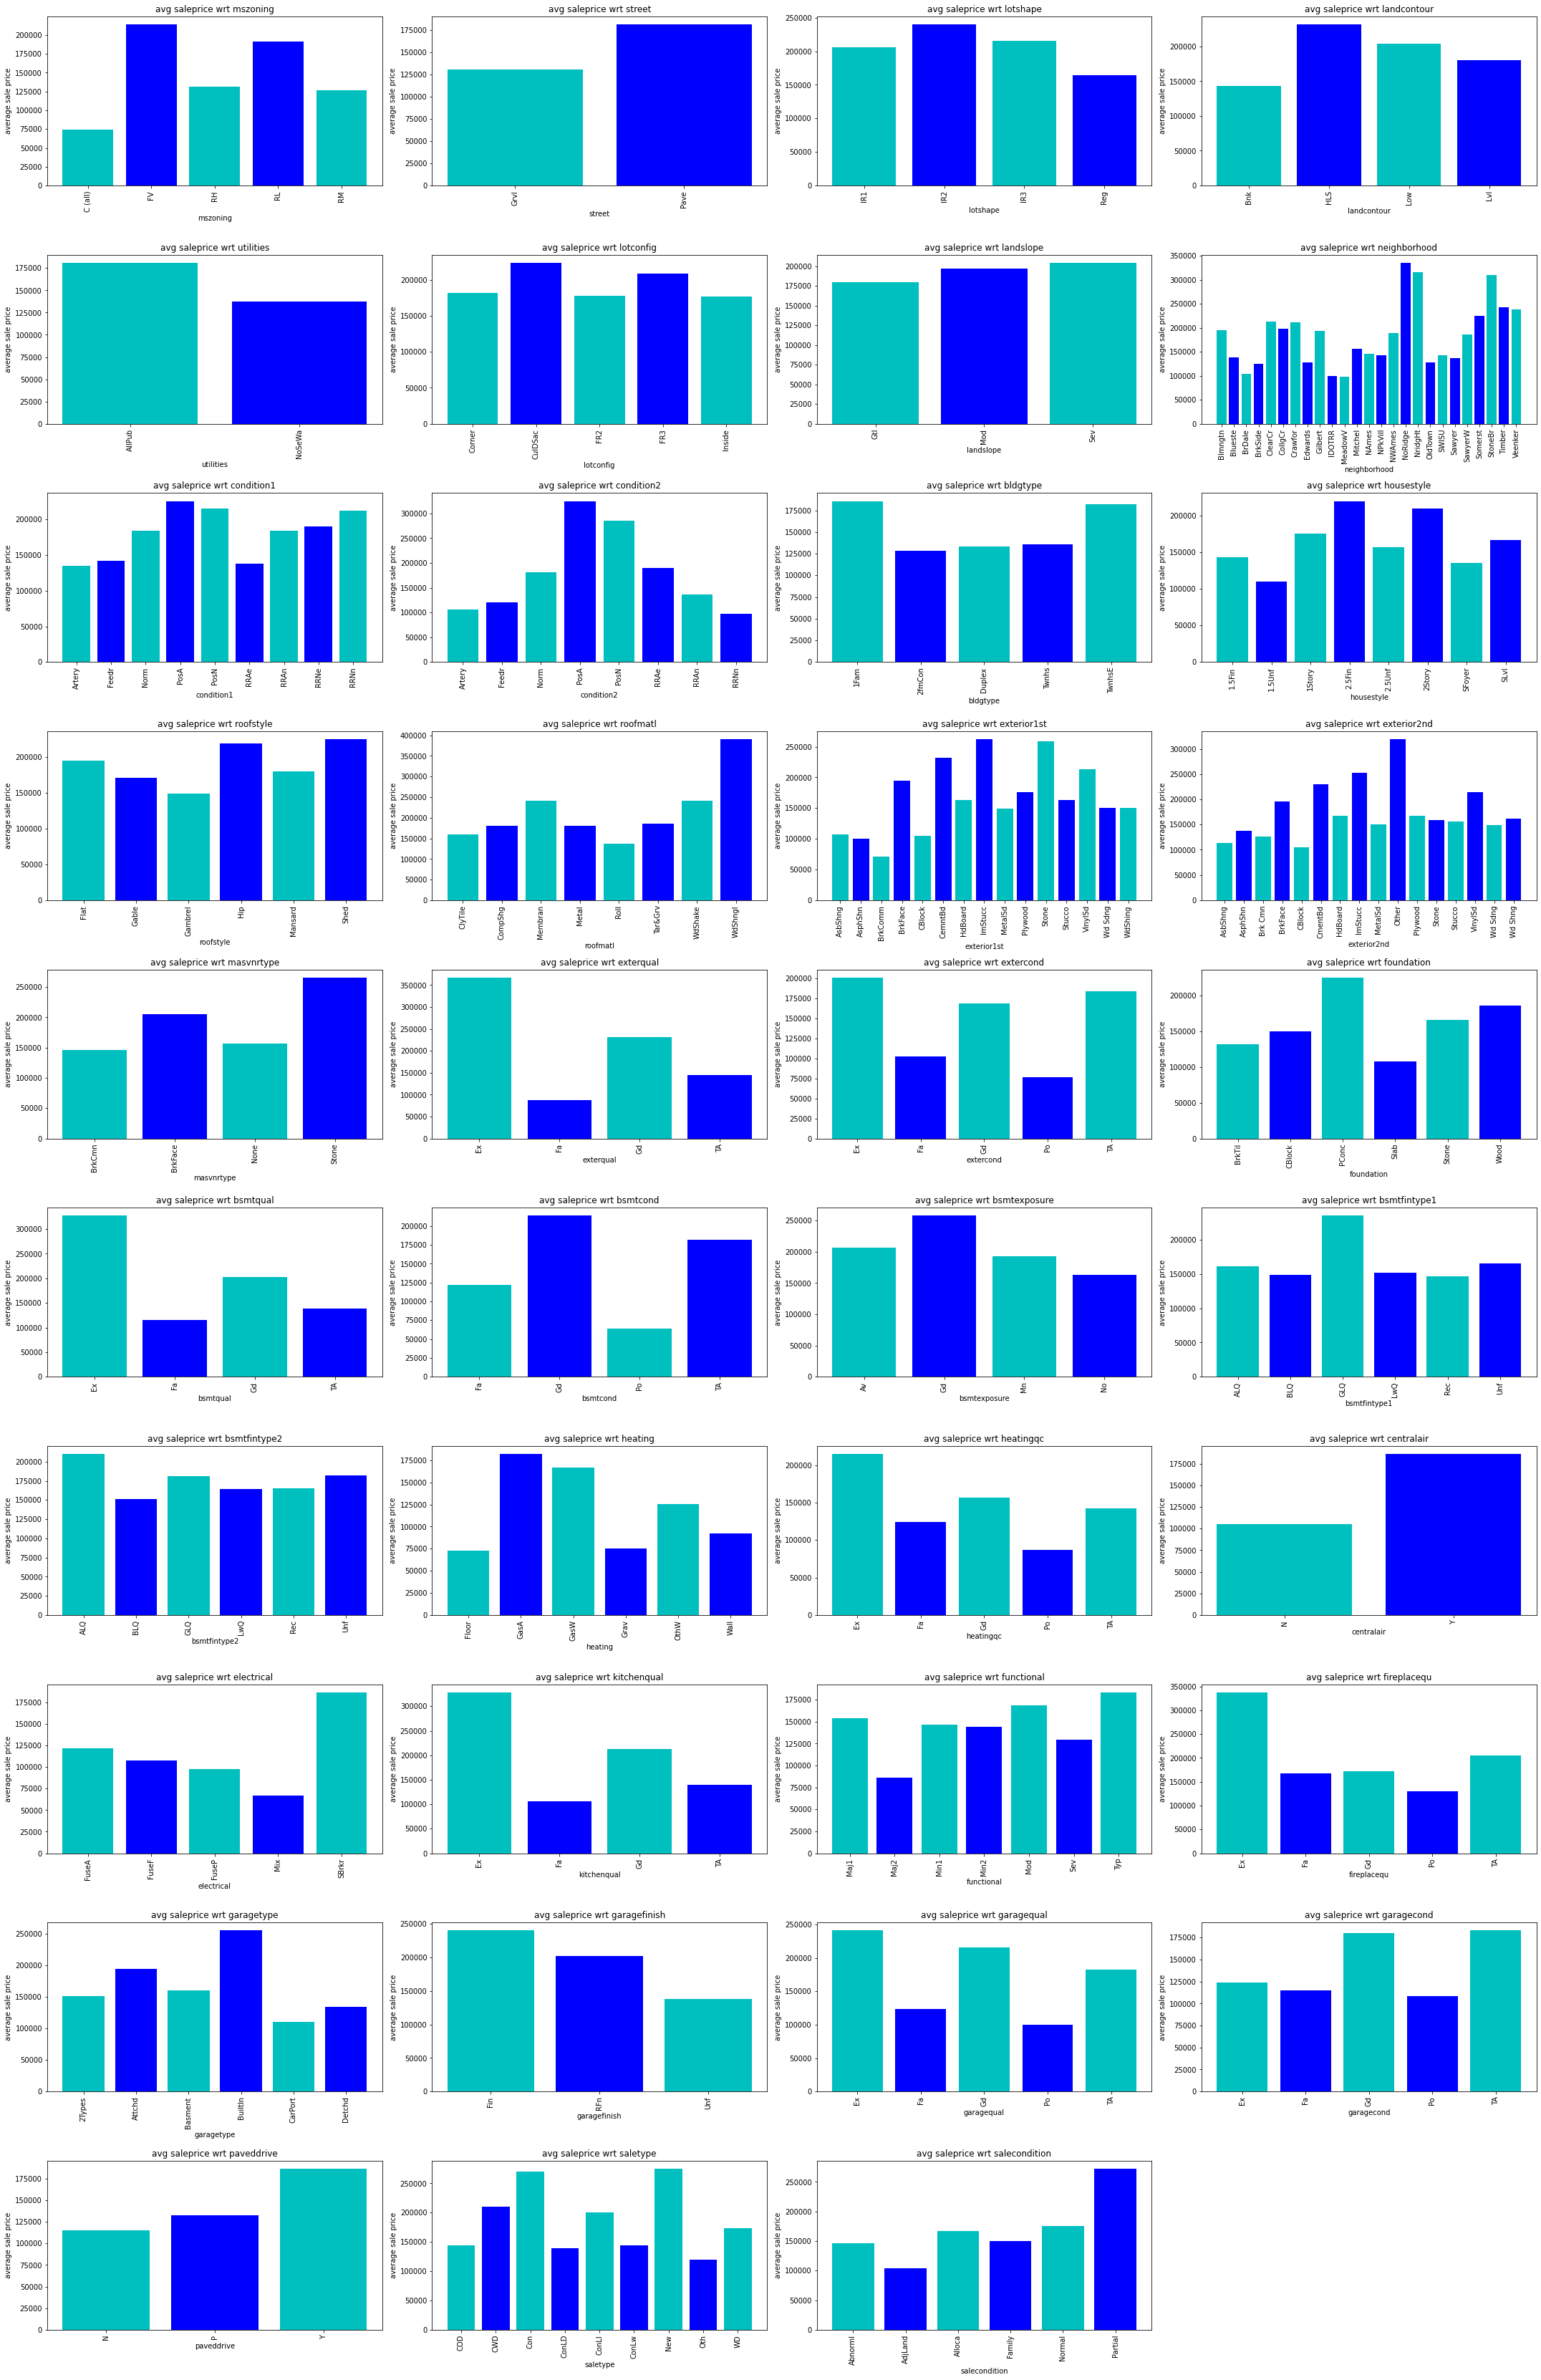

In [ ]:
plt.figure(figsize=(30,50))

for index, column in enumerate(categorical_col):
    plt.subplot(11,4,index+1)
    plt.bar(houseprices_df.groupby(column)["saleprice"].mean().index, 
            houseprices_df.groupby(column)["saleprice"].mean(), color = ('c', 'b'))
    plt.title("avg saleprice wrt {}".format(column))
    plt.ylabel("average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

The categorical variables I'll be selecting are mszoning, street, and extercond as these depict the most variance with respect to average sales price. 

In [ ]:
# processing select categorical columns to numerical variables
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.extercond, prefix="extercond", drop_first=True)], axis=1)

# **Regression Models**

Based off above analysis, I will select the following variables to include in our model.

>* total_area
* overallqual
* grlivarea
* garagecars
* garagearea
* totalbsmtsf
* firstflrsf
* house_age 
* mszoning_FV
* mszoning_RH
* mszoning_RL
* mszoning_RM
* street_Pave
* extercond_Fa
* extercond_Gd
* extercond_Po
* extercond_TA     


**Linear Regression**


In [ ]:
Y = np.log1p(houseprices_df['saleprice'])

X = houseprices_df[['total_area', 'overallqual', 'grlivarea', 'garagecars', 
                    'garagearea', 'totalbsmtsf', 'firstflrsf', 'house_age',
                    'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM',
                    'street_Pave', 'extercond_Fa', 'extercond_Gd', 
                    'extercond_Po', 'extercond_TA']]

# X is the feature set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print()
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("---------------Test set statistics---------------")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292

R-squared of the model in the training set is: 0.8289317950182749
---------------Test set statistics---------------
R-squared of the model in the test set is: 0.8517214713052681
Mean absolute error of the prediction is: 0.11557367513981262
Mean squared error of the prediction is: 0.02472479947281803
Root mean squared error of the prediction is: 0.1572412142945291
Mean absolute percentage error of the prediction is: 0.9667754394487259


> When initially running our model above, we got a few variables that were statistically insignificant such as yearbuilt with a p-value of 0.888 and grlivarea with a p-value of 0.701. This implies that the coefficient of yearbuilt and grlivarea is effectively zero from a statistical point of view. It's not only insignificant. There appears to be no relationship between sale price and and both year house was built and grlivarea.

I'll run a few models with different variables and choose the best one based off statistics.  

In [ ]:
# R-squared and adjusted R-squared of the model are 0.832 and 0.831 respectively. These are improvements upon the first model.
# F statistic and its associated p-value are 651.8 and 0.00 respectively. This also indicates that the second model is better than the first one.
# AIC and BIC of the model are -1117 and -1054 respectively. These values are lower than the ones of the first model. Hence, the second model is better than the first model.

**Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge

# cross-validation
alphas =[0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,
                0.008, 0.009, 0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1,
                10, 20, 30, 40, 60, 100, 150, 166, 200, 300, 500, 1000]

ridgeregr_cv = RidgeCV(alphas=alphas, cv=5)
ridgeregr_cv.fit(X_train, y_train)
print("Best Alpha:{}".format(ridgeregr_cv.alpha_))
print()

# We are making predictions here
y_preds_train = ridgeregr_cv.predict(X_train)
y_preds_test = ridgeregr_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best Alpha:1.0

R-squared of the model on the training set is: 0.8283688138016465
-----Test set statistics-----
R-squared of the model on the test set is: 0.8462270596804576
Mean absolute error of the prediction is: 0.1172535525017307
Mean squared error of the prediction is: 0.02564096870406415
Root mean squared error of the prediction is: 0.16012797601938317
Mean absolute percentage error of the prediction is: 0.9812957847507664


**Lasso**

In [ ]:
alphas = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,
                0.008, 0.009, 0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1,
                10, 20, 40, 60, 100, 150, 166, 200, 300, 500, 1000]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv = lasso_cv.fit(X_train, y_train)

print('Best Alpha: {}'.format(lasso_cv.alpha_))
print()

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best Alpha: 0.0001

R-squared of the model in training set is: 0.8286002908992902
-----Test set statistics-----
R-squared of the model in test set is: 0.8485642835775355
Mean absolute error of the prediction is: 0.11673897138433013
Mean squared error of the prediction is: 0.025251246788915528
Root mean squared error of the prediction is: 0.15890640889817984
Mean absolute percentage error of the prediction is: 0.9767597536955981


**ElasticNet Regression**

In [ ]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNetCV(alphas = alphas, cv=5) 
elasticregr = elasticregr.fit(X_train, y_train)

print('Best Alpha: {}'.format(elasticregr.alpha_))
print()

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best Alpha: 0.0001

R-squared of the model on the training set is: 0.8287743250990575
-----Test set statistics-----
R-squared of the model on the test set is: 0.8493786009140593
Mean absolute error of the prediction is: 0.11659276409664433
Mean squared error of the prediction is: 0.02511546291629407
Root mean squared error of the prediction is: 0.15847858819504315
Mean absolute percentage error of the prediction is: 0.9754184257384545


**Comparisions**

>**Linear Reg**
* R-squared of the model in the training set is: 0.8289317950182749
* R-squared of the model in the test set is: 0.8517214713052681
* Mean absolute error of the prediction is: 0.11557367513981262
* Mean squared error of the prediction is: 0.02472479947281803
* Root mean squared error of the prediction is: 0.1572412142945291
* Mean absolute percentage error of the prediction is: 0.9667754394487259


> **Ridge Reg**
* R-squared of the model on the training set is: 0.8283688138016465
* R-squared of the model on the test set is: 0.8462270596804576
* Mean absolute error of the prediction is: 0.1172535525017307
* Mean squared error of the prediction is: 0.02564096870406415
* Root mean squared error of the prediction is: 0.16012797601938317
* Mean absolute percentage error of the prediction is: 0.9812957847507664

>**Lasso Reg**
* R-squared of the model in training set is: 0.8286002908992902
* R-squared of the model in test set is: 0.8485642835775355
* Mean absolute error of the prediction is: 0.11673897138433013
* Mean squared error of the prediction is: 0.025251246788915528
* Root mean squared error of the prediction is: 0.15890640889817984
* Mean absolute percentage error of the prediction is: 0.9767597536955981


>**ElasticNet Reg**
* R-squared of the model on the training set is: 0.8287743250990575
* R-squared of the model on the test set is: 0.8493786009140593
* Mean absolute error of the prediction is: 0.11659276409664433
* Mean squared error of the prediction is: 0.02511546291629407
* Root mean squared error of the prediction is: 0.15847858819504315
* Mean absolute percentage error of the prediction is: 0.9754184257384545

Based our statistics, OLS is the better model. 

# **Outside factor**

For our external variable, I'll be adding interest rates for the state of Iowa.

Interest rates can be found at https://tax.iowa.gov/interest-rates.

In [ ]:
interest_rates = {2010: .05,
                  2009: .08,
                  2008: .10,
                  2007: .10,
                  2006: .08}

for i,year in enumerate(interest_rates):
  houseprices_df.loc[houseprices_df['yrsold'] == year, 'interest_rate']= interest_rates[year]

In [ ]:
houseprices_df['interest_rate'].value_counts()

0.08    652
0.10    633
0.05    175
Name: interest_rate, dtype: int64

Reworking model to add new feature, interest_rate.

**Revised Linear Regression**

In [ ]:
X = houseprices_df[['total_area', 'overallqual', 'grlivarea', 'garagecars', 
                    'garagearea', 'totalbsmtsf', 'firstflrsf', 'house_age',
                    'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM',
                    'street_Pave', 'extercond_Fa', 'extercond_Gd', 
                    'extercond_Po', 'extercond_TA', 'interest_rate']]

# X is the feature set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print()
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("---------------Test set statistics---------------")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292

R-squared of the model in the training set is: 0.8289450194972148
---------------Test set statistics---------------
R-squared of the model in the test set is: 0.8516248308002116
Mean absolute error of the prediction is: 0.11562234135792748
Mean squared error of the prediction is: 0.024740913856535665
Root mean squared error of the prediction is: 0.15729244691508765
Mean absolute percentage error of the prediction is: 0.9671828260753672


**Revised Ridge Regression**

In [ ]:
# cross-validation
alphas =[0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,
                0.008, 0.009, 0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1,
                10, 20, 30, 40, 60, 100, 150, 166, 200, 300, 500, 1000]

ridgeregr_cv = RidgeCV(alphas=alphas, cv=5)
ridgeregr_cv.fit(X_train, y_train)
print("Best Alpha:{}".format(ridgeregr_cv.alpha_))
print()

# We are making predictions here
y_preds_train = ridgeregr_cv.predict(X_train)
y_preds_test = ridgeregr_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best Alpha:1.0

R-squared of the model on the training set is: 0.8283771206816624
-----Test set statistics-----
R-squared of the model on the test set is: 0.8462106455259569
Mean absolute error of the prediction is: 0.11726020409124567
Mean squared error of the prediction is: 0.025643705692906166
Root mean squared error of the prediction is: 0.16013652204574122
Mean absolute percentage error of the prediction is: 0.9813534824423608


**Revised Lasso Regression**

In [ ]:
alphas = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007,
                0.008, 0.009, 0.01, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1,
                10, 20, 40, 60, 100, 150, 166, 200, 300, 500, 1000]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv = lasso_cv.fit(X_train, y_train)

print('Best Alpha: {}'.format(lasso_cv.alpha_))
print()

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best Alpha: 0.0001

R-squared of the model in training set is: 0.8286002908992902
-----Test set statistics-----
R-squared of the model in test set is: 0.8485642835775355
Mean absolute error of the prediction is: 0.11673897138433018
Mean squared error of the prediction is: 0.02525124678891553
Root mean squared error of the prediction is: 0.15890640889817984
Mean absolute percentage error of the prediction is: 0.9767597536955983


**Revised ElasticNet Regression**

In [ ]:
elasticregr = ElasticNetCV(alphas = alphas, cv=5) 
elasticregr = elasticregr.fit(X_train, y_train)

print('Best Alpha: {}'.format(elasticregr.alpha_))
print()

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best Alpha: 0.0001

R-squared of the model on the training set is: 0.8287743250990572
-----Test set statistics-----
R-squared of the model on the test set is: 0.8493786009140593
Mean absolute error of the prediction is: 0.11659276409664433
Mean squared error of the prediction is: 0.025115462916294056
Root mean squared error of the prediction is: 0.1584785881950431
Mean absolute percentage error of the prediction is: 0.9754184257384545


**Comparisons**

>**Lineaer Reg**
* R-squared of the model in the training set is: 0.8289450194972148
* R-squared of the model in the test set is: 0.8516248308002116
* Mean absolute error of the prediction is: 0.11562234135792748
* Mean squared error of the prediction is: 0.024740913856535665
* Root mean squared error of the prediction is: 0.15729244691508765
* Mean absolute percentage error of the prediction is: 0.9671828260753672

>**Ridge Reg**
* R-squared of the model on the training set is: 0.8283771206816624
* R-squared of the model on the test set is: 0.8462106455259569
* Mean absolute error of the prediction is: 0.11726020409124567
* Mean squared error of the prediction is: 0.025643705692906166
* Root mean squared error of the prediction is: 0.16013652204574122
* Mean absolute percentage error of the prediction is: 0.9813534824423608

>**Lasso Reg**
* R-squared of the model in training set is: 0.8286002908992902
* R-squared of the model in test set is: 0.8485642835775355
* Mean absolute error of the prediction is: 0.11673897138433018
* Mean squared error of the prediction is: 0.02525124678891553
* Root mean squared error of the prediction is: 0.15890640889817984
* Mean absolute percentage error of the prediction is: 0.9767597536955983

>**ElasticNet Reg**
* R-squared of the model on the training set is: 0.8287743250990572
* R-squared of the model on the test set is: 0.8493786009140593
* Mean absolute error of the prediction is: 0.11659276409664433
* Mean squared error of the prediction is: 0.025115462916294056
* Root mean squared error of the prediction is: 0.1584785881950431
* Mean absolute percentage error of the prediction is: 0.9754184257384545

Adding the outside variable did not change the performance of our model drastically. The better model is still Linear Regression.